In [2]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, LSTM, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import F1Score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support,confusion_matrix, classification_report, precision_score, recall_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import ConfusionMatrixDisplay
import os
import keras
from keras.metrics import Accuracy, Recall, Precision, TruePositives, FalseNegatives
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Reshape
import keras.backend as K
from sklearn.utils import class_weight
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import sys
drive.mount('/content/gdrive/')
prefix = '/content/gdrive/My Drive/'

def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

Mounted at /content/gdrive/


In [2]:
def run_model_df(data, lr=.012, epochs=200, thresh=-1, train=True, model_filepath='' ):
  #['X_train.pkl', 'X_val.pkl', 'X_test.pkl', 'y_train.pkl', 'y_val.pkl', 'y_test.pkl']
    X_train, X_val, X_test, y_test = data
    # print('a')
    training_df = pd.concat([X_train, X_val]) # X_train
    X_train = training_df.loc[:, training_df.columns != 'target'].values
    t = MinMaxScaler()
    X_train = t.fit_transform(X_train)
    X_val = t.transform(X_val.values)
    X_test = t.transform(X_test.values)
    print(X_train)
    input_dim = X_train.shape[1]

    input_img = keras.Input(shape=(input_dim,))
    encoded = Dense(int(0.75 * input_dim), activation='relu')(input_img)
    encoded = Dense(int(0.5 * input_dim), activation='relu')(encoded)
    encoded = Dense(int(0.33 * input_dim), activation='relu')(encoded)
    encoded = Dense(int(0.25 * input_dim), activation='relu')(encoded)

    decoded = Dense(int(0.33 * input_dim), activation='relu')(encoded)
    decoded = Dense(int(0.5 * input_dim), activation='relu')(decoded)
    decoded = Dense(int(0.75 * input_dim), activation='relu')(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)
    model = keras.Model(input_img, decoded)

    hlf = epochs
    callbacks = [ModelCheckpoint(filepath=model_filepath, monitor='val_loss', save_best_only=True),
          EarlyStopping(monitor='val_loss', patience=3, start_from_epoch=hlf)]


    opt = Adam(learning_rate=lr) if lr != -1 else Adam()
    metrics = ['accuracy', Recall(), Precision(), F1Score()] #[Accuracy(), Recall(), Precision(), TruePositives(), FalseNegatives(), F1Score()]
    model.compile(loss="mean_squared_error", optimizer=opt, metrics=metrics)

    print('begin training')


    #history = model.fit(X_train, X_train, epochs=epochs, batch_size=64, validation_data=(X_val, X_val),
    history = model.fit(X_train, X_train, epochs=epochs, batch_size=1024, validation_split=.2,
                            callbacks=callbacks, shuffle=True)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()

    model = load_model(model_filepath, custom_objects={'f1_score':f1_score})
    del X_train
    X_val_prediction = model.predict(X_val)
    mse = np.mean(np.power(X_val - X_val_prediction, 2), axis=1)
    print("mean is %.5f" % mse.mean())
    print("min is %.5f" % mse.min())
    print("max is %.5f" % mse.max())
    print("std is %.5f" % mse.std())


    tr_calc = mse.mean() + mse.std()
    print("calculated tr is {}, given tr is {}".format(tr_calc, thresh))
    X_test_prediction = model.predict(X_test)
    testing_mse = np.mean(np.power(X_test - X_test_prediction, 2), axis=1)

    #1 = botnet
    y_true = np.asarray([0 if label == 'benign' else 1 for label in y_test])

    #With provided threshold
    test_labels_calc = np.asarray([0 if testing_mse[i] <= tr_calc else 1 for i in range(len(testing_mse))])
    test_labels_given = np.asarray([0 if testing_mse[i] <= thresh else 1 for i in range(len(testing_mse))])


    cr_calc = classification_report(y_true, test_labels_calc)
    cm_calc = confusion_matrix(y_true, test_labels_calc)
    cm_calc = cm_calc.astype('float') / cm_calc.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize = (10,7))
    ConfusionMatrixDisplay.from_predictions(y_true, test_labels_calc)
    plt.show()
    print(cr_calc)
    print(cm_calc)

    print('With the given threshold')
    cr = classification_report(y_true, test_labels_given)
    cm = confusion_matrix(y_true, test_labels_given)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    ConfusionMatrixDisplay.from_predictions(y_true, test_labels_given)
    plt.show()
    print(cr)
    print(cm)




In [3]:
# pth = '/content/gdrive/MyDrive/Network Security/pkl_files/hybrid/'
# training_data = [pd.read_pickle(pth + fn) for fn in ['X_train.pkl', 'X_test.pkl', 'y_train.pkl', 'y_test.pkl']]

def train_hybrid_model(training_data, epochs=100, lr=0.001, model_filepath=''):
  X_train, X_test, y_train, y_test = training_data

  #This is fucky-wucky to reduce the imbalance
  # X_train = pd.concat([X_train, y_train], axis=1)
  # print(X_train.shape)
  # X_train = X_train.append([X_train[X_train['target'] == 'benign']] * 10, ignore_index=True)
  # print(X_train.shape)
  # y_train =  X_train.loc[:, X_train.columns == 'target'].values
  X_train = X_train.loc[:, X_train.columns != 'target'].values

  t = MinMaxScaler()
  X_train = t.fit_transform(X_train)

  y_train = LabelEncoder().fit_transform(y_train).astype(float)#(y_train!='benign').astype(int).astype(float)
  class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
  print('Uniquye train', np.unique(y_train, return_counts=True))
  print(class_weights)
  cws = {0: 50000, 1: 1}
  y_train = y_train.reshape(-1,1)
  print(y_train.shape)

  input_dim = X_train.shape[1]
  print(y_train.dtype)

  y_test2 = y_test.to_numpy()
  print('unique test' ,np.unique(y_test2, return_counts=True))
  y_test3 = (y_test2!='benign').astype(int)
  print('unique test' , np.unique(y_test3, return_counts=True))
  y_test4 = y_test3.reshape(-1,1)

  input_img = keras.Input(shape=(input_dim,))

  encoded = Dense(int(0.75 * input_dim), activation='relu')(input_img)
  encoded = Dense(int(.5 * input_dim), activation='relu')(encoded)
  encoded = Dense(int(.33 * input_dim), activation='relu')(encoded)
  encoded = Dense(int(0.25 * input_dim), activation='relu')(encoded)

  # conv = Reshape((int(0.75 * input_dim),1))(encoded)
  conv = Reshape((int(.25 * input_dim),1))(encoded)
  conv = Conv1D(16,5, activation='relu')(conv)
  conv = MaxPooling1D()(conv)
  conv = Conv1D(16,5, activation='relu')(conv)
  conv = MaxPooling1D()(conv)
  conv = Flatten()(conv)
  conv = Dense(64, activation='relu')(conv)
  conv = Dense(1, activation='softmax')(conv)
  # conv = Dense(1, activation='sigmoid')(encoded)
  model = Model(input_img, conv)

  hlf = epochs // 2
  callbacks = [ModelCheckpoint(filepath=model_filepath, monitor='val_loss', save_best_only=True),
               EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=hlf)]

  opt = Adam(learning_rate=lr) if lr != -1 else Adam()
  metrics = ['accuracy', Recall(), Precision(), F1Score()]
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)

  print(X_test.shape, np.unique(y_test, return_counts=True))
  print('begin training')


  history = model.fit(X_train, y_train, epochs=epochs, batch_size=1024, validation_split=.2,
                          callbacks=callbacks, shuffle=True, class_weight=cws)
  print(history.history)
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='val')
  plt.legend()
  plt.show()

  model = load_model(model_filepath, custom_objects={'f1_score':f1_score})
  X_prediction = model.predict(X_test)
  print(y_test4)
  print(X_prediction)

  # mse = np.mean(np.power(y_test4 - X_prediction, 2), axis=1)
  # print("mean is %.5f" % mse.mean())
  # print("min is %.5f" % mse.min())
  # print("max is %.5f" % mse.max())
  # print("std is %.5f" % mse.std())

  test_labels = np.asarray([0 if X_prediction[i] < .5 else 1 for i in range(len(X_prediction))])
  cr = classification_report(y_test4, test_labels)
  cm = confusion_matrix(y_test4, test_labels)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  plt.figure(figsize = (10,7))
  ConfusionMatrixDisplay.from_predictions(y_test4, test_labels, display_labels=['benign', 'malicious'])
  plt.show()
  print(cr)
  print(cm)


In [12]:
def train_cnn_model(training_data, epochs=100, lr=0.001, model_filepath=''):
  X_train, X_test, y_train, y_test = training_data

  X_train = X_train.loc[:, X_train.columns != 'target'].values

  t = MinMaxScaler()
  X_train = t.fit_transform(X_train)

  y_train = LabelEncoder().fit_transform(y_train).astype(float) #(y_train!='benign').astype(int).astype(float)
  class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
  print('Uniquye train', np.unique(y_train, return_counts=True))
  print(class_weights)
  cws = {0: 50000, 1: 1}
  y_train = y_train.reshape(-1,1)
  print(y_train.shape)

  input_dim = X_train.shape[1]
  print(y_train.dtype)

  y_test2 = y_test.to_numpy()
  print('unique test' ,np.unique(y_test2, return_counts=True))
  y_test3 = (y_test2!='benign').astype(int)
  print('unique test' , np.unique(y_test3, return_counts=True))
  y_test4 = y_test3.reshape(-1,1)

  input_img = keras.Input(shape=(input_dim,1))

  conv = Conv1D(64,5, activation='relu')(input_img)
  conv = MaxPooling1D()(conv)
  conv = Conv1D(32,5, activation='relu')(conv)
  conv = MaxPooling1D()(conv)
  conv = LSTM(32, return_sequences=True)(conv)
  conv = MaxPooling1D()(conv)
  conv = LSTM(16, return_sequences=True)(conv)
  conv = MaxPooling1D()(conv)

  conv = Flatten()(conv)
  conv = Dense(128, activation='relu')(conv)
  conv = Dense(64, activation='relu')(conv)
  conv = Dense(1, activation='softmax')(conv)
  model = Model(input_img, conv)

  hlf = epochs // 2
  callbacks = [ModelCheckpoint(filepath=model_filepath, monitor='val_loss', save_best_only=True),
               EarlyStopping(monitor='val_loss', patience=5, start_from_epoch=hlf)]

  opt = Adam(learning_rate=lr)
  metrics = ['accuracy', Recall(), Precision(), F1Score()]
  model.compile(loss="binary_crossentropy", optimizer=opt, metrics=metrics)
  model.summary()
  print(X_test.shape, np.unique(y_test, return_counts=True))
  print('begin training')


  history = model.fit(X_train, y_train, epochs=epochs, batch_size=1024, validation_split=.2,
                          callbacks=callbacks, shuffle=True, class_weight=cws)
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='val')
  plt.legend()
  plt.show()

  model = load_model(model_filepath, custom_objects={'f1_score':f1_score})
  X_prediction = model.predict(X_test)
  print(y_test4)
  print(X_prediction)

  # mse = np.mean(np.power(y_test4 - X_prediction, 2), axis=1)
  # print("mean is %.5f" % mse.mean())
  # print("min is %.5f" % mse.min())
  # print("max is %.5f" % mse.max())
  # print("std is %.5f" % mse.std())

  test_labels = np.asarray([0 if X_prediction[i] < .5 else 1 for i in range(len(X_prediction))])
  cr = classification_report(y_test4, test_labels)
  cm = confusion_matrix(y_test4, test_labels)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  plt.figure(figsize = (10,7))
  ConfusionMatrixDisplay.from_predictions(y_test4, test_labels, display_labels=['benign', 'malicious'])
  plt.show()
  print(cr)
  print(cm)


#BaIoT training datasets:

In [5]:
devices = {
  "Danmini_Doorbell": {"id": 1,
                       "lr": .012,
                       "epochs": 800,
                       "tr": .042
                       },
  "Ennio_Doorbell": {"id": 2,
                       "lr": .003,
                       "epochs": 350,
                       "tr": .011
                       },
  "Ecobee_Thermostat": {"id": 3,
                       "lr": .028,
                       "epochs": 250,
                       "tr": .011
                       },
  "Philips_B120N10_Baby_Monitor": {"id": 4,
                       "lr": .016,
                       "epochs": 100,
                       "tr": .030
                       },
  "Provision_PT_737E_Security_Camera": {"id": 5,
                       "lr": .026,
                       "epochs": 300,
                       "tr": .035
                       },
  "Provision_PT_838_Security_Camera": {"id": 6,
                       "lr": .008,
                       "epochs": 450,
                       "tr": .038
                       },
  "SimpleHome_XCS7_1002_WHT_Security_Camera": {"id": 7,
                       "lr": .017,
                       "epochs": 230,
                       "tr": .056
                       },
  "SimpleHome_XCS7_1003_WHT_Security_Camera": {"id": 8,
                       "lr": .006,
                       "epochs": 500,
                       "tr": .004
                       },
  "Samsung_SNH_1011_N_Webcam": {"id": 9,
                       "lr": .013,
                       "epochs": 150,
                       "tr": .074
                       },
}

In [6]:
model_storage = '/content/gdrive/MyDrive/Network Security/models/'
pkl_files = '/content/gdrive/MyDrive/Network Security/pkl_files/'

def autoencoder_device_train(name):
  amodel = model_storage + name
  apath = pkl_files + name + '/'
  device = devices[name]
  data = [pd.read_pickle(apath + fn) for fn in ['X_train.pkl', 'X_val.pkl', 'X_test.pkl', 'y_test.pkl']]
  run_model_df(data, lr=device["lr"], epochs=device["epochs"], thresh=device["tr"], train=True, model_filepath=amodel)

def hybrid_device_train(name):
  hmodel = model_storage + 'hybrid/' + name
  hpath = pkl_files + 'hybrid/' + name + '/'
  hybrid_data = [pd.read_pickle(hpath + fn) for fn in ['X_train.pkl', 'X_test.pkl', 'y_train.pkl', 'y_test.pkl']]
  train_hybrid_model(hybrid_data, epochs=200, lr=-1, model_filepath=hmodel)

def cnn_device_train(name):
  cmodel = model_storage + 'cnn/' + name
  cpath = pkl_files + 'hybrid/' + name + '/'
  hybrid_data = [pd.read_pickle(cpath + fn) for fn in ['X_train.pkl', 'X_test.pkl', 'y_train.pkl', 'y_test.pkl']]
  train_hybrid_model(hybrid_data, epochs=200, model_filepath=cmodel)

# Device 1: Simplehome 1002


[[3.43102586e-01 1.69722024e-02 6.48498702e-05 ... 0.00000000e+00
  3.37515169e-01 4.44787454e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.37515169e-01 4.44787454e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  3.37515169e-01 4.44787454e-01]
 ...
 [1.06433152e-04 4.59955516e-02 4.18658924e-17 ... 1.60753946e-17
  3.37515169e-01 4.44787454e-01]
 [0.00000000e+00 4.59955516e-02 0.00000000e+00 ... 1.36599208e-17
  3.37515169e-01 4.44787454e-01]
 [1.95017453e-10 1.93665480e-08 2.48455496e-08 ... 4.72683235e-18
  3.37515169e-01 4.44787454e-01]]
begin training
Epoch 1/230
224/224 [==============================] - 8s 20ms/step - loss: 0.0097 - accuracy: 0.1209 - recall_1: 0.2110 - precision_1: 0.9899 - f1_score: 0.0332 - val_loss: 8.7323e-04 - val_accuracy: 0.3658 - val_recall_1: 0.1974 - val_precision_1: 1.0000 - val_f1_score: 0.0304
Epoch 2/230
224/224 [==============================] - 2s 11ms/step - loss: 6.4837e-04 - accuracy: 0.2089

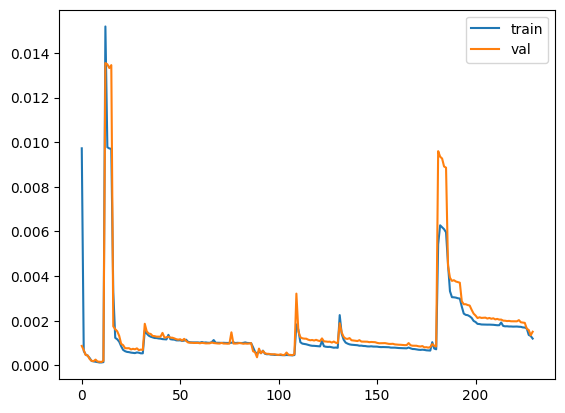

195/195 [==============================] - 0s 2ms/step
mean is 0.00040
min is 0.00001
max is 0.04704
std is 0.00140
calculated tr is 0.001798450027215538, given tr is 0.056
2187/2187 [==============================] - 4s 2ms/step


<Figure size 1000x700 with 0 Axes>

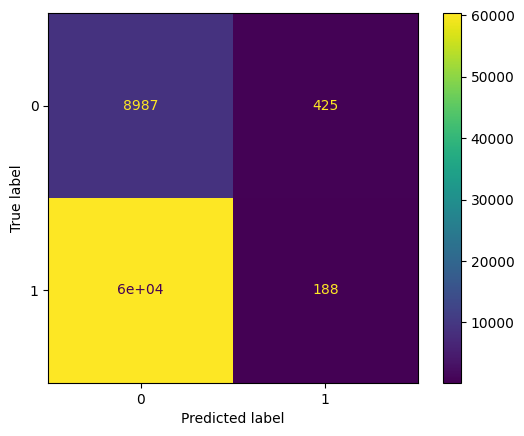

              precision    recall  f1-score   support

           0       0.13      0.95      0.23      9412
           1       0.31      0.00      0.01     60550

    accuracy                           0.13     69962
   macro avg       0.22      0.48      0.12     69962
weighted avg       0.28      0.13      0.04     69962

[[0.95484488 0.04515512]
 [0.99689513 0.00310487]]
With the given threshold


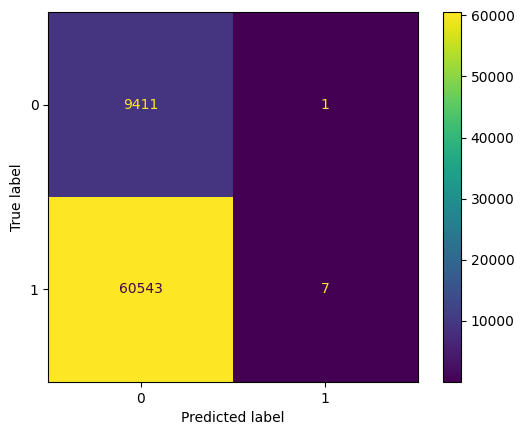

              precision    recall  f1-score   support

           0       0.13      1.00      0.24      9412
           1       0.88      0.00      0.00     60550

    accuracy                           0.13     69962
   macro avg       0.50      0.50      0.12     69962
weighted avg       0.78      0.13      0.03     69962

[[9.99893753e-01 1.06247344e-04]
 [9.99884393e-01 1.15606936e-04]]


In [14]:
autoencoder_device_train('SimpleHome_XCS7_1002_WHT_Security_Camera')

Uniquye train (array([0., 1.]), array([ 37173, 242673]))
[3.76410298 0.57659072]
(279846, 1)
float64
unique test (array(['benign', 'malicious'], dtype=object), array([ 9412, 60550]))
unique test (array([0, 1]), array([ 9412, 60550]))
(69962, 115) (array(['benign', 'malicious'], dtype=object), array([ 9412, 60550]))
begin training
Epoch 1/200
219/219 [==============================] - 8s 24ms/step - loss: 138.2362 - accuracy: 0.2800 - recall_9: 0.1705 - precision_9: 0.9964 - f1_score: 0.9132 - val_loss: 2.2968 - val_accuracy: 0.4067 - val_recall_9: 0.3155 - val_precision_9: 1.0000 - val_f1_score: 0.9611
Epoch 2/200
219/219 [==============================] - 3s 12ms/step - loss: 2.6273 - accuracy: 0.4247 - recall_9: 0.3366 - precision_9: 1.0000 - f1_score: 0.9676 - val_loss: 1.1777 - val_accuracy: 0.4369 - val_recall_9: 0.3503 - val_precision_9: 1.0000 - val_f1_score: 0.9594
Epoch 3/200
219/219 [==============================] - 3s 13ms/step - loss: 2.4466 - accuracy: 0.5066 - recall_9: 

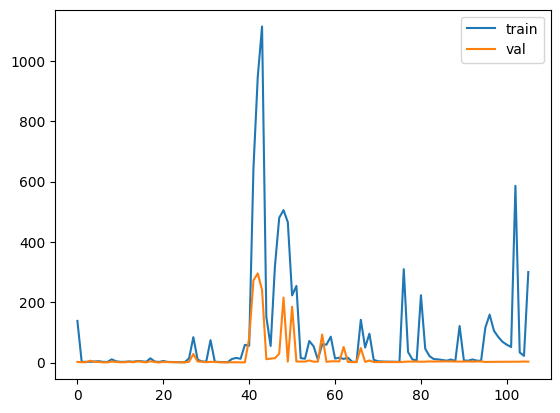

2187/2187 [==============================] - 4s 2ms/step
[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [1]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [0.]
 [1.]]


<Figure size 1000x700 with 0 Axes>

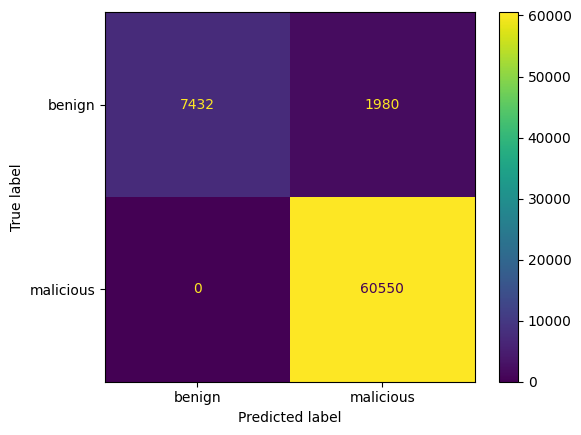

              precision    recall  f1-score   support

           0       1.00      0.79      0.88      9412
           1       0.97      1.00      0.98     60550

    accuracy                           0.97     69962
   macro avg       0.98      0.89      0.93     69962
weighted avg       0.97      0.97      0.97     69962

[[0.78963026 0.21036974]
 [0.         1.        ]]


In [43]:
# hmodel = model_storage + 'hybrid/simplehome1002'
# hpath = pkl_files + 'hybrid/SimpleHome_XCS7_1002_WHT_Security_Camera/'
# hybrid_data = [pd.read_pickle(hpath + fn) for fn in ['X_train.pkl', 'X_test.pkl', 'y_train.pkl', 'y_test.pkl']]
# train_hybrid_model(hybrid_data, epochs=30, lr=-1, model_filepath=hmodel)

hybrid_device_train('SimpleHome_XCS7_1002_WHT_Security_Camera')

Uniquye train (array([0., 1.]), array([ 37173, 242673]))
[3.76410298 0.57659072]
(279846, 1)
float64
unique test (array(['benign', 'malicious'], dtype=object), array([ 9412, 60550]))
unique test (array([0, 1]), array([ 9412, 60550]))
(69962, 115) (array(['benign', 'malicious'], dtype=object), array([ 9412, 60550]))
begin training
Epoch 1/200
219/219 [==============================] - 5s 13ms/step - loss: 177.9218 - accuracy: 0.2432 - recall_10: 0.1274 - precision_10: 0.9997 - f1_score: 0.9211 - val_loss: 5.9001 - val_accuracy: 0.3721 - val_recall_10: 0.2756 - val_precision_10: 1.0000 - val_f1_score: 0.9980
Epoch 2/200
219/219 [==============================] - 3s 12ms/step - loss: 5.2293 - accuracy: 0.4164 - recall_10: 0.3271 - precision_10: 1.0000 - f1_score: 0.9588 - val_loss: 2.0636 - val_accuracy: 0.4040 - val_recall_10: 0.3123 - val_precision_10: 1.0000 - val_f1_score: 0.9604
Epoch 3/200
219/219 [==============================] - 3s 15ms/step - loss: 3.5049 - accuracy: 0.4981 - re

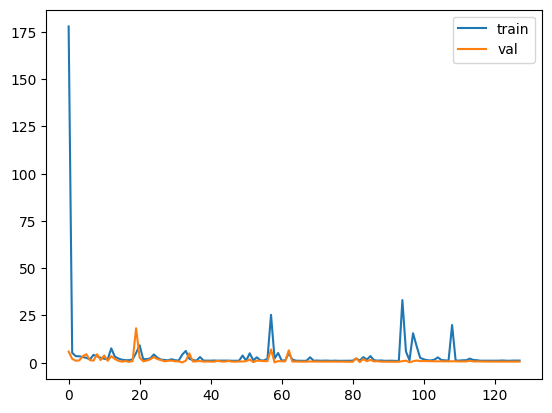

2187/2187 [==============================] - 4s 2ms/step
[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [1]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [0.]
 [1.]]


<Figure size 1000x700 with 0 Axes>

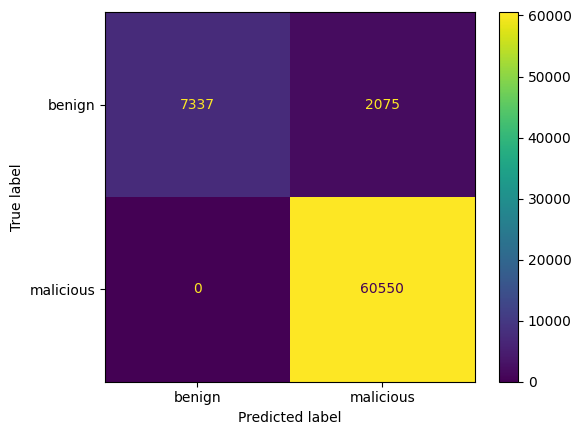

              precision    recall  f1-score   support

           0       1.00      0.78      0.88      9412
           1       0.97      1.00      0.98     60550

    accuracy                           0.97     69962
   macro avg       0.98      0.89      0.93     69962
weighted avg       0.97      0.97      0.97     69962

[[0.77953676 0.22046324]
 [0.         1.        ]]


In [44]:
cnn_device_train('SimpleHome_XCS7_1002_WHT_Security_Camera')

#Device 2: Simplehome 1003


[[0.00000000e+00 1.38777878e-17 0.00000000e+00 ... 0.00000000e+00
  3.29753845e-01 4.26132595e-01]
 [0.00000000e+00 1.38777878e-17 0.00000000e+00 ... 0.00000000e+00
  3.29753845e-01 4.26132595e-01]
 [0.00000000e+00 1.38777878e-17 0.00000000e+00 ... 0.00000000e+00
  3.29753845e-01 4.26132595e-01]
 ...
 [0.00000000e+00 1.38777878e-17 0.00000000e+00 ... 0.00000000e+00
  3.29753845e-01 4.26132595e-01]
 [0.00000000e+00 1.38777878e-17 0.00000000e+00 ... 0.00000000e+00
  3.29753845e-01 4.26132595e-01]
 [5.17868049e-01 1.72691905e-02 7.04199194e-06 ... 1.89727483e-18
  3.29753845e-01 4.26132595e-01]]
begin training
Epoch 1/500
4200/4200 [==============================] - 24s 5ms/step - loss: 0.0012 - accuracy: 0.2127 - recall_21: 0.2220 - precision_21: 0.9990 - f1_score: 0.0329 - val_loss: 0.0014 - val_accuracy: 0.9462 - val_recall_21: 0.0774 - val_precision_21: 0.9998 - val_f1_score: 0.0190
Epoch 2/500
4200/4200 [==============================] - 21s 5ms/step - loss: 1.7372e-04 - accuracy: 0.

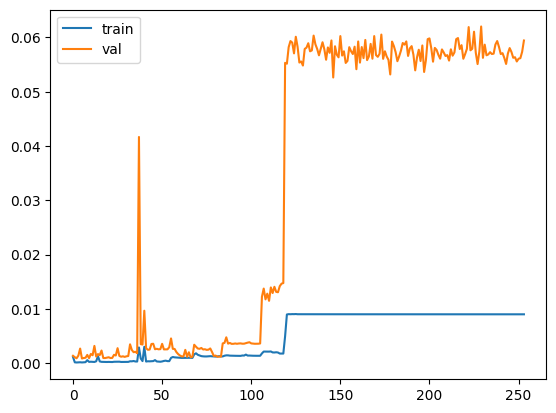

82/82 [==============================] - 0s 4ms/step
mean is 0.00088
min is 0.00000
max is 0.05642
std is 0.00344
calculated tr is 0.0043201822991495486, given tr is 0.004
2100/2100 [==============================] - 4s 2ms/step


<Figure size 1000x700 with 0 Axes>

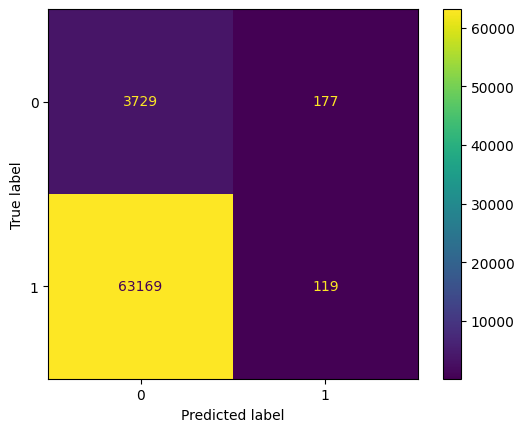

              precision    recall  f1-score   support

           0       0.06      0.95      0.11      3906
           1       0.40      0.00      0.00     63288

    accuracy                           0.06     67194
   macro avg       0.23      0.48      0.05     67194
weighted avg       0.38      0.06      0.01     67194

[[0.9546851  0.0453149 ]
 [0.99811971 0.00188029]]
With the given threshold


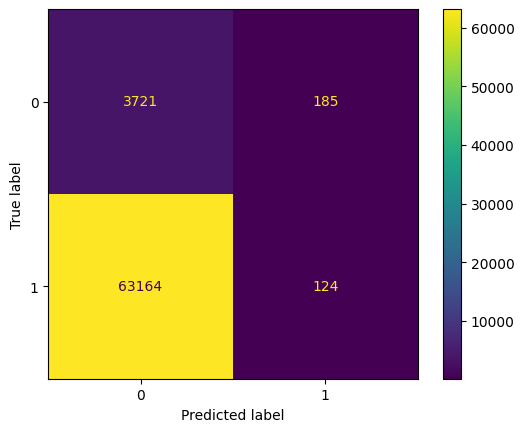

              precision    recall  f1-score   support

           0       0.06      0.95      0.11      3906
           1       0.40      0.00      0.00     63288

    accuracy                           0.06     67194
   macro avg       0.23      0.48      0.05     67194
weighted avg       0.38      0.06      0.01     67194

[[0.95263697 0.04736303]
 [0.9980407  0.0019593 ]]


In [ ]:
autoencoder_device_train('SimpleHome_XCS7_1003_WHT_Security_Camera')

Uniquye train (array([0., 1.]), array([ 15622, 253150]))
[8.60235565 0.53085522]
(268772, 1)
float64
unique test (array(['benign', 'malicious'], dtype=object), array([ 3906, 63288]))
unique test (array([0, 1]), array([ 3906, 63288]))
(67194, 115) (array(['benign', 'malicious'], dtype=object), array([ 3906, 63288]))
begin training
Epoch 1/200
105/105 [==============================] - 11s 89ms/step - loss: 152.2816 - accuracy: 0.0699 - recall_4: 0.0127 - precision_4: 0.9579 - f1_score: 0.9553 - val_loss: 1.3563 - val_accuracy: 0.2605 - val_recall_4: 0.2160 - val_precision_4: 1.0000 - val_f1_score: 0.9710
Epoch 2/200
105/105 [==============================] - 5s 46ms/step - loss: 2.5103 - accuracy: 0.3108 - recall_4: 0.2680 - precision_4: 1.0000 - f1_score: 0.9812 - val_loss: 1.4065 - val_accuracy: 0.3661 - val_recall_4: 0.3279 - val_precision_4: 1.0000 - val_f1_score: 0.9879
Epoch 3/200
105/105 [==============================] - 8s 81ms/step - loss: 2.1038 - accuracy: 0.3858 - recall_4:

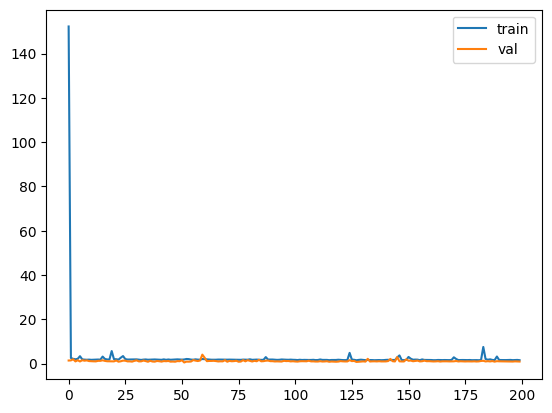

2100/2100 [==============================] - 6s 3ms/step
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


<Figure size 1000x700 with 0 Axes>

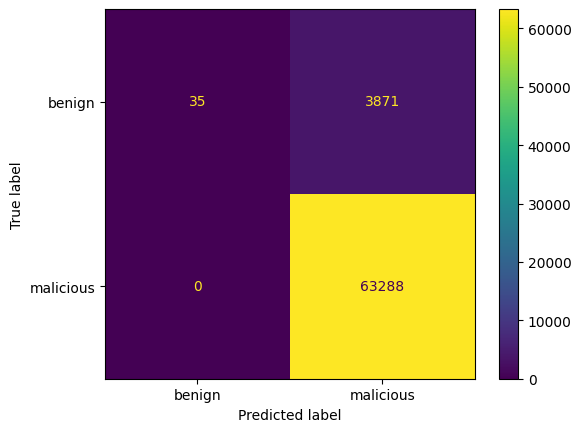

              precision    recall  f1-score   support

           0       1.00      0.01      0.02      3906
           1       0.94      1.00      0.97     63288

    accuracy                           0.94     67194
   macro avg       0.97      0.50      0.49     67194
weighted avg       0.95      0.94      0.91     67194

[[0.00896057 0.99103943]
 [0.         1.        ]]


In [ ]:
# hmodel = model_storage + 'hybrid/simplehome1003'
# hpath = pkl_files + 'hybrid/SimpleHome_XCS7_1003_WHT_Security_Camera/'
# hybrid_data = [pd.read_pickle(hpath + fn) for fn in ['X_train.pkl', 'X_test.pkl', 'y_train.pkl', 'y_test.pkl']]
# train_hybrid_model(hybrid_data, epochs=30, lr=0.001, model_filepath=hmodel)

hybrid_device_train('SimpleHome_XCS7_1003_WHT_Security_Camera')

# Device 3: Danmini Doorbell

In [ ]:
autoencoder_device_train('Danmini_Doorbell')

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  7.39219950e-03 2.61200068e-01]
 [5.78220291e-01 1.69691369e-02 2.66833045e-06 ... 0.00000000e+00
  7.39219950e-03 2.61200068e-01]
 [5.53685332e-01 1.70163545e-02 8.03358325e-06 ... 0.00000000e+00
  7.39219950e-03 2.61200068e-01]
 ...
 [1.79542564e-08 2.76760076e-07 5.52000526e-08 ... 2.12901846e-18
  7.39219950e-03 2.61200068e-01]
 [6.59054149e-03 5.08371886e-02 1.04664731e-17 ... 1.93698935e-17
  7.39219950e-03 2.61200068e-01]
 [7.22305738e-03 4.77867171e-02 5.72187894e-04 ... 3.79883686e-18
  7.39219950e-03 2.61200068e-01]]
begin training
Epoch 1/800
3745/3745 [==============================] - 30s 6ms/step - loss: 0.0014 - accuracy: 0.3496 - recall_5: 0.1375 - precision_5: 0.9985 - f1_score: 0.0405 - val_loss: 0.0012 - val_accuracy: 0.8628 - val_recall_5: 0.1192 - val_precision_5: 1.0000 - val_f1_score: 0.0241
Epoch 2/800
3745/3745 [==============================] - 20s 5ms/step - loss: 7.1028e-04 - accuracy: 0.6514

KeyboardInterrupt: ignored

[3.69952518 0.57813659]
['benign' 'malicious']
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
float64
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 115)]             0         
                                                                 
 dense (Dense)               (None, 86)                9976      
                                                                 
 dense_1 (Dense)             (None, 57)                4959      
                                                                 
 dense_2 (Dense)             (None, 37)                2146      
                                                                 
 dense_3 (Dense)             (None, 28)                1064      
                                                                 
 reshape (Reshape)           (None, 7, 4)              0         
                              

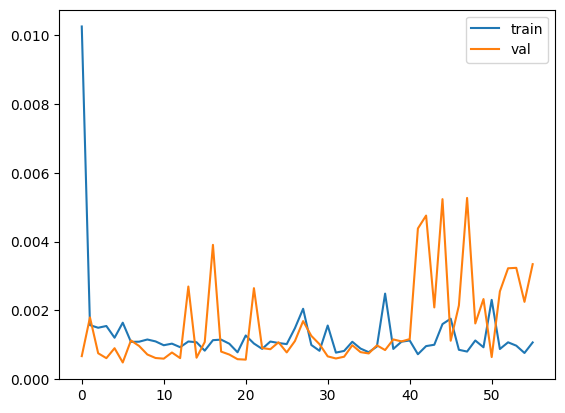

2289/2289 [==============================] - 3s 1ms/step
mean is 0.13591
min is 0.00000
max is 1.00000
std is 0.34269


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1000x700 with 0 Axes>

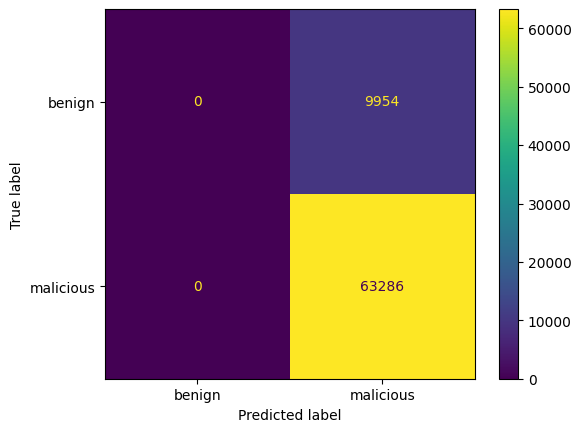

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      9954
           1       0.86      1.00      0.93     63286

    accuracy                           0.86     73240
   macro avg       0.43      0.50      0.46     73240
weighted avg       0.75      0.86      0.80     73240

[[0. 1.]
 [0. 1.]]


In [ ]:
hybrid_device_train('Danmini_Doorbell')

# Device 4: Ecobee Thermostat

[[0.00000000e+00 6.93889390e-18 0.00000000e+00 ... 0.00000000e+00
  2.14196666e-01 3.10931162e-01]
 [0.00000000e+00 6.93889390e-18 0.00000000e+00 ... 0.00000000e+00
  2.14196666e-01 3.10931162e-01]
 [2.35897241e-07 8.92667474e-07 1.35849953e-07 ... 1.34211654e-18
  2.14196666e-01 3.10931162e-01]
 ...
 [0.00000000e+00 6.93889390e-18 0.00000000e+00 ... 0.00000000e+00
  2.14196666e-01 3.10931162e-01]
 [0.00000000e+00 6.93889390e-18 0.00000000e+00 ... 0.00000000e+00
  2.14196666e-01 3.10931162e-01]
 [5.40866078e-01 1.34359503e-02 2.03469214e-06 ... 1.89836374e-18
  2.14196666e-01 3.10931162e-01]]
begin training
Epoch 1/250
4047/4047 [==============================] - 16s 4ms/step - loss: 0.0945 - accuracy: 7.7222e-06 - recall_1: 0.1635 - precision_1: 0.8907 - f1_score: 0.0703 - val_loss: 0.0870 - val_accuracy: 0.0017 - val_recall_1: 0.1171 - val_precision_1: 0.9608 - val_f1_score: 0.0560
Epoch 2/250
4047/4047 [==============================] - 10s 2ms/step - loss: 0.0945 - accuracy: 7.7222

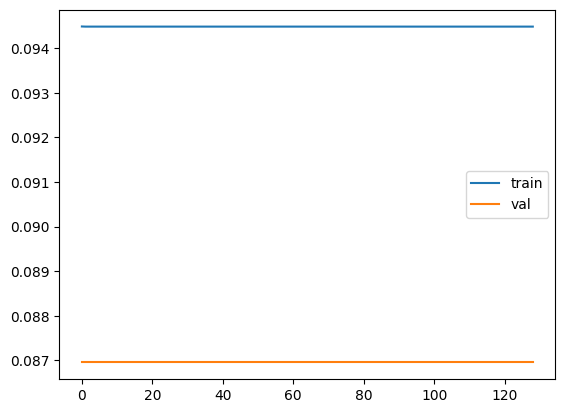

55/55 [==============================] - 0s 1ms/step
mean is 0.08695
min is 0.06105
max is 0.17515
std is 0.01820
calculated tr is 0.1051518161985572, given tr is 0.011
2024/2024 [==============================] - 3s 1ms/step


<Figure size 1000x700 with 0 Axes>

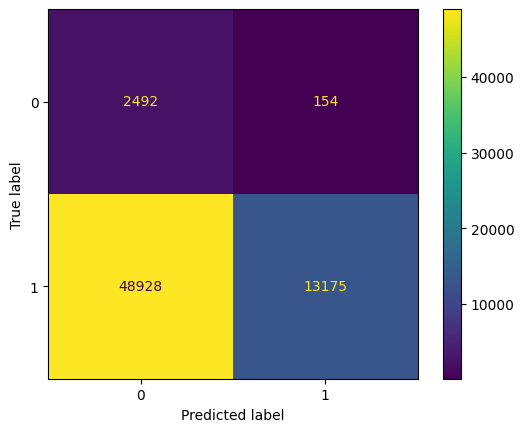

              precision    recall  f1-score   support

           0       0.05      0.94      0.09      2646
           1       0.99      0.21      0.35     62103

    accuracy                           0.24     64749
   macro avg       0.52      0.58      0.22     64749
weighted avg       0.95      0.24      0.34     64749

[[0.94179894 0.05820106]
 [0.78785244 0.21214756]]
With the given threshold


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


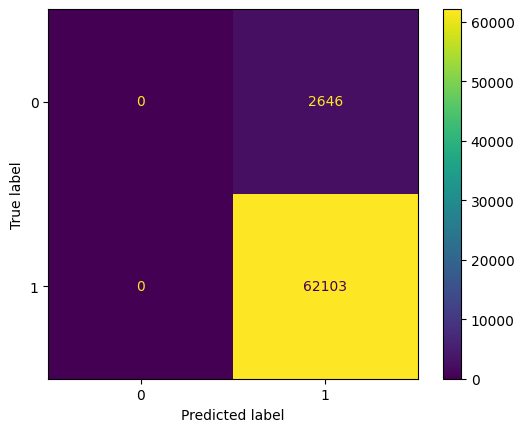

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2646
           1       0.96      1.00      0.98     62103

    accuracy                           0.96     64749
   macro avg       0.48      0.50      0.49     64749
weighted avg       0.92      0.96      0.94     64749

[[0. 1.]
 [0. 1.]]


In [ ]:
autoencoder_device_train('Ecobee_Thermostat')

[12.37193083  0.52105807]
['benign' 'malicious']
[[1.]
 [1.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]
float64
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 115)]             0         
                                                                 
 dense (Dense)               (None, 86)                9976      
                                                                 
 dense_1 (Dense)             (None, 57)                4959      
                                                                 
 dense_2 (Dense)             (None, 37)                2146      
                                                                 
 dense_3 (Dense)             (None, 28)                1064      
                                                                 
 reshape (Reshape)           (None, 7, 4)              0         
                            

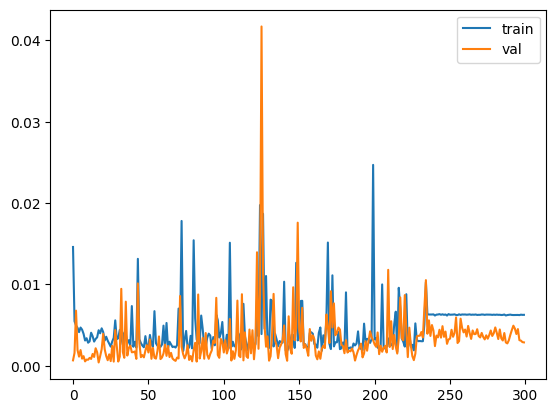

2024/2024 [==============================] - 4s 2ms/step
mean is 0.04087
min is 0.00000
max is 1.00000
std is 0.19798


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1000x700 with 0 Axes>

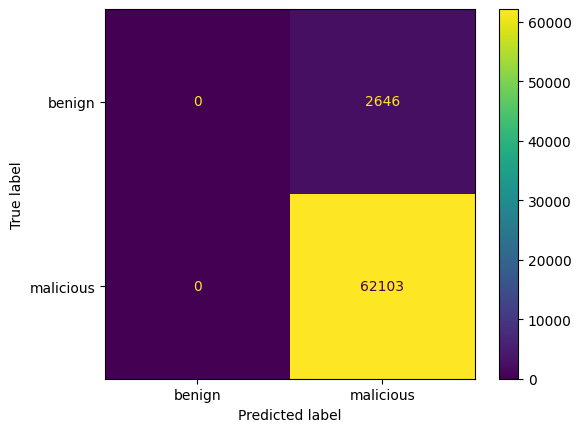

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2646
           1       0.96      1.00      0.98     62103

    accuracy                           0.96     64749
   macro avg       0.48      0.50      0.49     64749
weighted avg       0.92      0.96      0.94     64749

[[0. 1.]
 [0. 1.]]


In [ ]:
hybrid_device_train('Ecobee_Thermostat')

# !!!Device 5 Samsung

[[1.35343398e-02 3.12473654e-02 6.70560114e-03 ... 1.17536544e-02
  4.52390026e-01 4.20844718e-01]
 [0.00000000e+00 3.27361497e-01 0.00000000e+00 ... 9.80271636e-04
  4.52390025e-01 4.20821214e-01]
 [1.00160246e-01 3.51652113e-01 7.88218252e-04 ... 9.23835296e-04
  4.52390025e-01 4.20821214e-01]
 ...
 [0.00000000e+00 3.27361497e-01 7.69983107e-14 ... 9.80270488e-04
  4.52390025e-01 4.20821214e-01]
 [1.86411518e-09 1.91626243e-09 1.20528093e-09 ... 1.12327722e-18
  4.52390025e-01 4.20821214e-01]
 [0.00000000e+00 3.27361497e-01 1.76146820e-14 ... 9.80262257e-04
  4.52390025e-01 4.20821214e-01]]
begin training
Epoch 1/150
28/28 [==============================] - 4s 83ms/step - loss: 0.0349 - accuracy: 0.0683 - recall_14: 0.1339 - precision_14: 0.9661 - f1_score: 0.0111 - val_loss: 0.0121 - val_accuracy: 0.0013 - val_recall_14: 0.0576 - val_precision_14: 0.9999 - val_f1_score: 0.0068
Epoch 2/150
28/28 [==============================] - 1s 49ms/step - loss: 0.0075 - accuracy: 0.2195 - recal

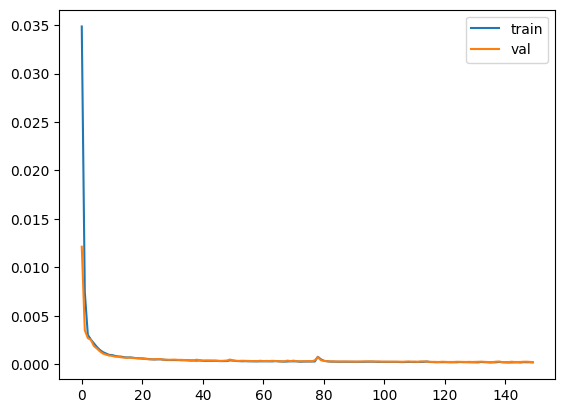

218/218 [==============================] - 0s 2ms/step
mean is 0.00022
min is 0.00001
max is 0.03220
std is 0.00098
calculated tr is 0.0011922936039304728, given tr is 0.074
10640/10640 [==============================] - 18s 2ms/step


<Figure size 1000x700 with 0 Axes>

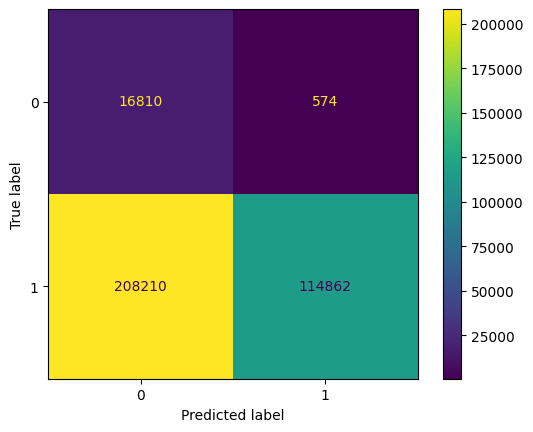

              precision    recall  f1-score   support

           0       0.07      0.97      0.14     17384
           1       1.00      0.36      0.52    323072

    accuracy                           0.39    340456
   macro avg       0.53      0.66      0.33    340456
weighted avg       0.95      0.39      0.50    340456

[[0.96698113 0.03301887]
 [0.64446934 0.35553066]]
With the given threshold


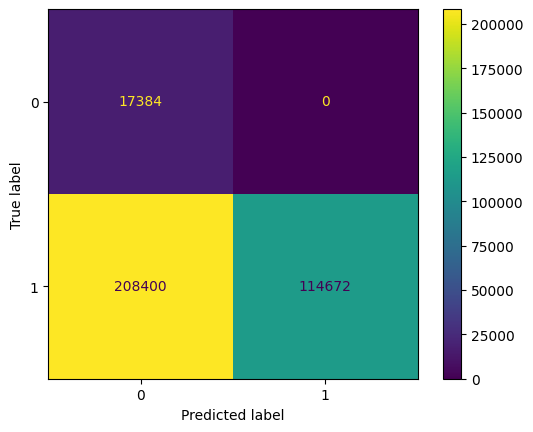

              precision    recall  f1-score   support

           0       0.08      1.00      0.14     17384
           1       1.00      0.35      0.52    323072

    accuracy                           0.39    340456
   macro avg       0.54      0.68      0.33    340456
weighted avg       0.95      0.39      0.50    340456

[[1.         0.        ]
 [0.64505745 0.35494255]]


In [49]:
autoencoder_device_train('Samsung_SNH_1011_N_Webcam')

Uniquye train (array([0., 1.]), array([ 41631, 258546]))
[3.60521006 0.58050985]
(300177, 1)
float64
unique test (array(['benign', 'gafgyt_combo', 'gafgyt_junk', 'gafgyt_scan',
       'gafgyt_tcp', 'gafgyt_udp'], dtype=object), array([ 17384,  58669,  28305,  27698,  97783, 110617]))
unique test (array([0, 1]), array([ 17384, 323072]))
(340456, 115) (array(['benign', 'gafgyt_combo', 'gafgyt_junk', 'gafgyt_scan',
       'gafgyt_tcp', 'gafgyt_udp'], dtype=object), array([ 17384,  58669,  28305,  27698,  97783, 110617]))
begin training
Epoch 1/200
235/235 [==============================] - 7s 20ms/step - loss: 141.0308 - accuracy: 0.4570 - recall_12: 0.3696 - precision_12: 0.9996 - f1_score: 0.9808 - val_loss: 0.0791 - val_accuracy: 0.9982 - val_recall_12: 0.9979 - val_precision_12: 1.0000 - val_f1_score: 0.9876
Epoch 2/200
235/235 [==============================] - 1s 6ms/step - loss: 3.2903 - accuracy: 0.5743 - recall_12: 0.5056 - precision_12: 1.0000 - f1_score: 0.9838 - val_loss: 1.58

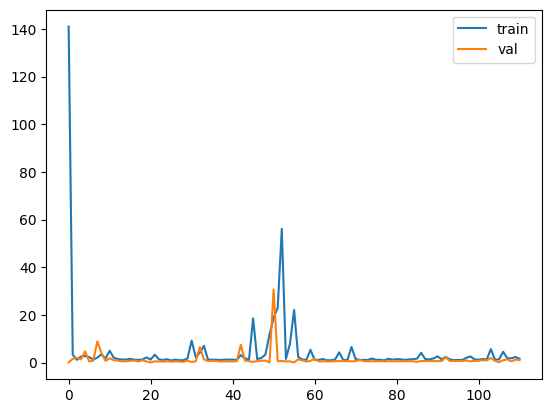

10640/10640 [==============================] - 18s 2ms/step
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
[[1.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


<Figure size 1000x700 with 0 Axes>

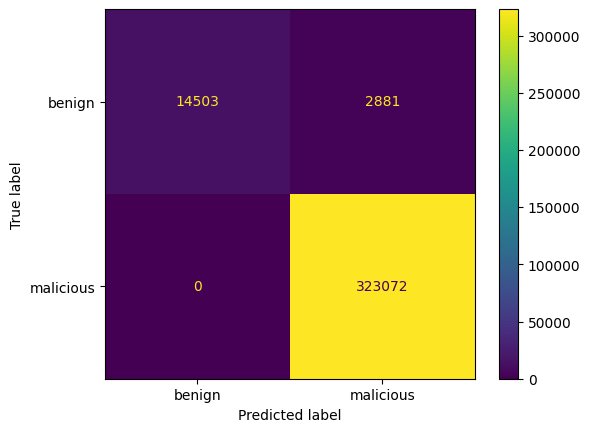

              precision    recall  f1-score   support

           0       1.00      0.83      0.91     17384
           1       0.99      1.00      1.00    323072

    accuracy                           0.99    340456
   macro avg       1.00      0.92      0.95    340456
weighted avg       0.99      0.99      0.99    340456

[[0.83427289 0.16572711]
 [0.         1.        ]]


In [46]:
hybrid_device_train('Samsung_SNH_1011_N_Webcam')

Uniquye train (array([0., 1.]), array([ 41631, 258546]))
[3.60521006 0.58050985]
(300177, 1)
float64
unique test (array(['benign', 'gafgyt_combo', 'gafgyt_junk', 'gafgyt_scan',
       'gafgyt_tcp', 'gafgyt_udp'], dtype=object), array([ 17384,  58669,  28305,  27698,  97783, 110617]))
unique test (array([0, 1]), array([ 17384, 323072]))
(340456, 115) (array(['benign', 'gafgyt_combo', 'gafgyt_junk', 'gafgyt_scan',
       'gafgyt_tcp', 'gafgyt_udp'], dtype=object), array([ 17384,  58669,  28305,  27698,  97783, 110617]))
begin training
Epoch 1/200
235/235 [==============================] - 5s 12ms/step - loss: 176.5767 - accuracy: 0.4522 - recall_13: 0.3645 - precision_13: 0.9984 - f1_score: 0.9744 - val_loss: 0.1990 - val_accuracy: 0.9967 - val_recall_13: 0.9962 - val_precision_13: 1.0000 - val_f1_score: 0.9864
Epoch 2/200
235/235 [==============================] - 1s 6ms/step - loss: 2.9587 - accuracy: 0.5201 - recall_13: 0.4427 - precision_13: 1.0000 - f1_score: 0.9701 - val_loss: 0.81

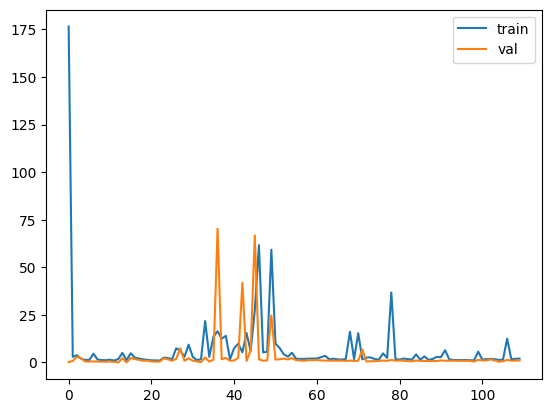

10640/10640 [==============================] - 18s 2ms/step
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
[[1.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [1.]]


<Figure size 1000x700 with 0 Axes>

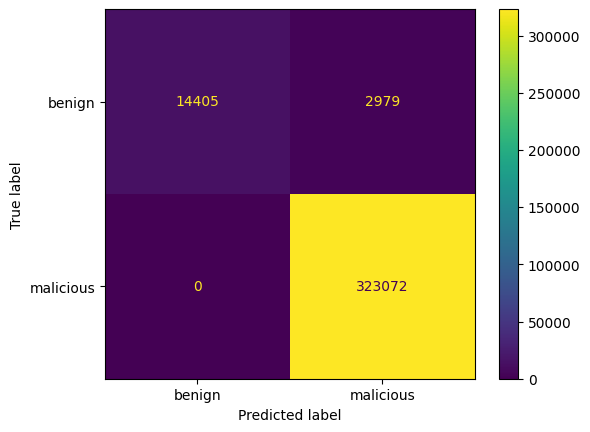

              precision    recall  f1-score   support

           0       1.00      0.83      0.91     17384
           1       0.99      1.00      1.00    323072

    accuracy                           0.99    340456
   macro avg       1.00      0.91      0.95    340456
weighted avg       0.99      0.99      0.99    340456

[[0.82863553 0.17136447]
 [0.         1.        ]]


In [47]:
cnn_device_train('Samsung_SNH_1011_N_Webcam')

# !!!Device 6 Philips

[[3.78103025e-02 4.30818735e-03 0.00000000e+00 ... 4.66576055e-04
  5.81252102e-01 4.64690388e-01]
 [1.45648174e-06 4.30818736e-03 4.14171693e-13 ... 5.07995406e-04
  5.81251107e-01 4.62144335e-01]
 [1.77200447e-05 4.30818735e-03 1.91107649e-18 ... 4.41744911e-04
  5.81254710e-01 4.75370828e-01]
 ...
 [4.31001573e-02 3.64331804e-03 4.86458452e-05 ... 4.98722885e-04
  5.81252734e-01 4.70032730e-01]
 [1.37118416e-02 5.31153759e-03 2.60297541e-04 ... 9.47045687e-04
  5.81387488e-01 6.42107700e-01]
 [1.27711297e-02 4.30818736e-03 3.11154369e-13 ... 5.46754850e-04
  5.81250394e-01 4.65371904e-01]]
begin training
Epoch 1/100
1461/1461 [==============================] - 12s 7ms/step - loss: 0.0021 - accuracy: 0.8908 - recall: 0.0237 - precision: 0.9991 - f1_score: 0.0235 - val_loss: 0.0021 - val_accuracy: 0.9082 - val_recall: 0.0231 - val_precision: 1.0000 - val_f1_score: 0.0480
Epoch 2/100
1461/1461 [==============================] - 7s 5ms/step - loss: 0.0050 - accuracy: 0.9087 - recall: 0.

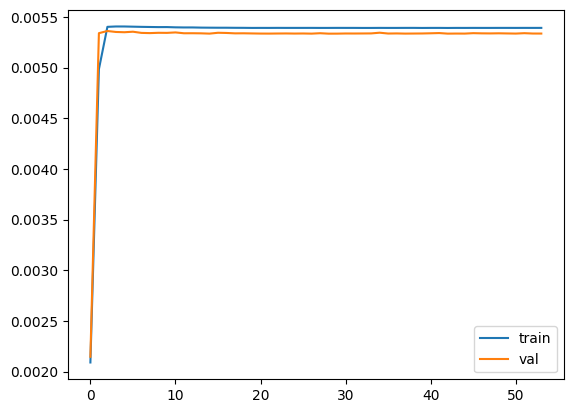

731/731 [==============================] - 1s 2ms/step
mean is 0.00215
min is 0.00004
max is 0.32570
std is 0.01183
calculated tr is 0.013971679295874128, given tr is 0.03
30683/30683 [==============================] - 61s 2ms/step


<Figure size 1000x700 with 0 Axes>

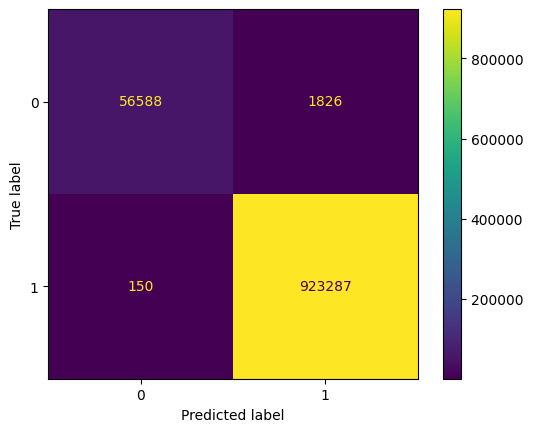

              precision    recall  f1-score   support

           0       1.00      0.97      0.98     58414
           1       1.00      1.00      1.00    923437

    accuracy                           1.00    981851
   macro avg       1.00      0.98      0.99    981851
weighted avg       1.00      1.00      1.00    981851

[[9.68740370e-01 3.12596295e-02]
 [1.62436636e-04 9.99837563e-01]]
With the given threshold


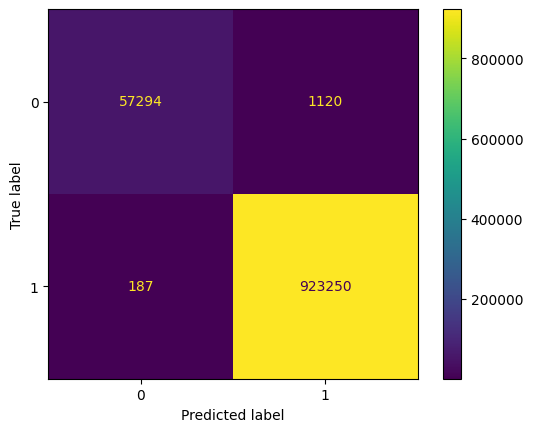

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     58414
           1       1.00      1.00      1.00    923437

    accuracy                           1.00    981851
   macro avg       1.00      0.99      0.99    981851
weighted avg       1.00      1.00      1.00    981851

[[9.80826514e-01 1.91734858e-02]
 [2.02504340e-04 9.99797496e-01]]


In [ ]:
autoencoder_device_train('Philips_B120N10_Baby_Monitor')

Uniquye train (array([0., 1.]), array([140456, 738485]))
[3.12888378 0.5950974 ]
(878941, 1)
float64
unique test (array(['benign', 'gafgyt_combo', 'gafgyt_junk', 'gafgyt_scan',
       'gafgyt_tcp', 'gafgyt_udp', 'mirai_ack', 'mirai_scan', 'mirai_syn',
       'mirai_udp', 'mirai_udpplain'], dtype=object), array([ 58414,  58152,  28349,  27859,  92581, 105782,  91123, 103621,
       118128, 217034,  80808]))
unique test (array([0, 1]), array([ 58414, 923437]))
(981851, 115) (array(['benign', 'gafgyt_combo', 'gafgyt_junk', 'gafgyt_scan',
       'gafgyt_tcp', 'gafgyt_udp', 'mirai_ack', 'mirai_scan', 'mirai_syn',
       'mirai_udp', 'mirai_udpplain'], dtype=object), array([ 58414,  58152,  28349,  27859,  92581, 105782,  91123, 103621,
       118128, 217034,  80808]))
begin training
Epoch 1/200
687/687 [==============================] - 11s 12ms/step - loss: 48.5202 - accuracy: 0.7600 - recall_16: 0.7145 - precision_16: 0.9999 - f1_score: 0.9483 - val_loss: 1.1407 - val_accuracy: 0.8136 - v

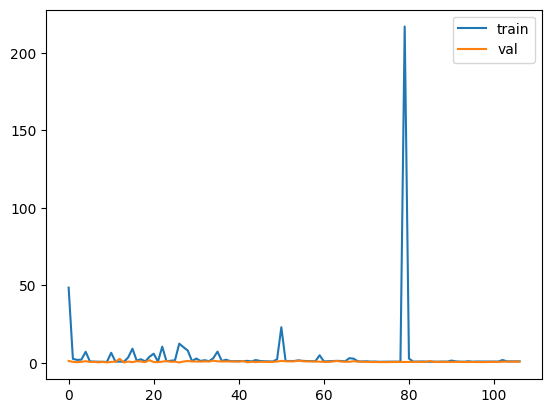

30683/30683 [==============================] - 53s 2ms/step
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


<Figure size 1000x700 with 0 Axes>

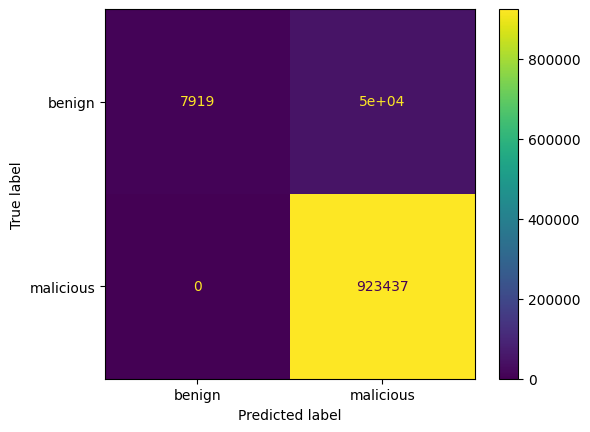

              precision    recall  f1-score   support

           0       1.00      0.14      0.24     58414
           1       0.95      1.00      0.97    923437

    accuracy                           0.95    981851
   macro avg       0.97      0.57      0.61    981851
weighted avg       0.95      0.95      0.93    981851

[[0.13556682 0.86443318]
 [0.         1.        ]]


In [52]:
hybrid_device_train('Philips_B120N10_Baby_Monitor')

Uniquye train (array([0., 1.]), array([140456, 738485]))
[3.12888378 0.5950974 ]
(878941, 1)
float64
unique test (array(['benign', 'gafgyt_combo', 'gafgyt_junk', 'gafgyt_scan',
       'gafgyt_tcp', 'gafgyt_udp', 'mirai_ack', 'mirai_scan', 'mirai_syn',
       'mirai_udp', 'mirai_udpplain'], dtype=object), array([ 58414,  58152,  28349,  27859,  92581, 105782,  91123, 103621,
       118128, 217034,  80808]))
unique test (array([0, 1]), array([ 58414, 923437]))
(981851, 115) (array(['benign', 'gafgyt_combo', 'gafgyt_junk', 'gafgyt_scan',
       'gafgyt_tcp', 'gafgyt_udp', 'mirai_ack', 'mirai_scan', 'mirai_syn',
       'mirai_udp', 'mirai_udpplain'], dtype=object), array([ 58414,  58152,  28349,  27859,  92581, 105782,  91123, 103621,
       118128, 217034,  80808]))
begin training
Epoch 1/200
687/687 [==============================] - 9s 9ms/step - loss: 85.0755 - accuracy: 0.6983 - recall_15: 0.6412 - precision_15: 0.9995 - f1_score: 0.9368 - val_loss: 0.5964 - val_accuracy: 0.8164 - val

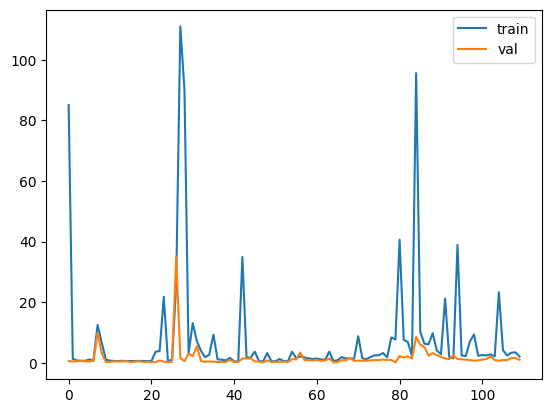

30683/30683 [==============================] - 54s 2ms/step
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


<Figure size 1000x700 with 0 Axes>

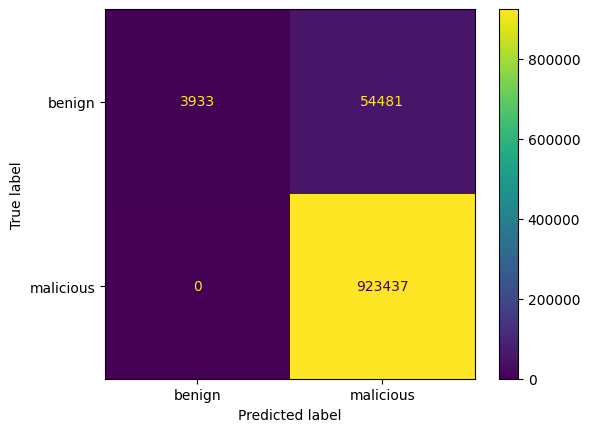

              precision    recall  f1-score   support

           0       1.00      0.07      0.13     58414
           1       0.94      1.00      0.97    923437

    accuracy                           0.94    981851
   macro avg       0.97      0.53      0.55    981851
weighted avg       0.95      0.94      0.92    981851

[[0.06732975 0.93267025]
 [0.         1.        ]]


In [51]:
cnn_device_train('Philips_B120N10_Baby_Monitor')

# MedbIoT dataset

In [ ]:

# #Processing for autoencoder
# x = len(benign)*2//3

# benign_train = benign.iloc[:x]
# benign_test = benign.iloc[x:].reset_index(drop=True)
# full_test = pd.concat([benign_test, mal], axis=0, ignore_index=True)
# y_test = full_test['target']
# x_test = full_test[test_data.columns[:-1]]
# x_test.tail()


4744/4744 [==============================] - 29s 6ms/step - loss: 2.5569e-06 - accuracy: 0.9855 - recall_2: 0.1500 - precision_2: 1.0000 - f1_score: 0.0173 - val_loss: 2.4106e-06 - val_accuracy: 0.9877 - val_recall_2: 0.1500 - val_precision_2: 1.0000 - val_f1_score: 0.0173
Epoch 109/300
4744/4744 [==============================] - 27s 6ms/step - loss: 2.5361e-06 - accuracy: 0.9854 - recall_2: 0.1500 - precision_2: 1.0000 - f1_score: 0.0174 - val_loss: 2.7193e-06 - val_accuracy: 0.9858 - val_recall_2: 0.1500 - val_precision_2: 1.0000 - val_f1_score: 0.0175
Epoch 110/300
4744/4744 [==============================] - 27s 6ms/step - loss: 2.5196e-06 - accuracy: 0.9853 - recall_2: 0.1500 - precision_2: 1.0000 - f1_score: 0.0174 - val_loss: 1.2640e-05 - val_accuracy: 0.9830 - val_recall_2: 0.1499 - val_precision_2: 1.0000 - val_f1_score: 0.0172
Epoch 111/300
4744/4744 [==============================] - 27s 6ms/step - loss: 2.5218e-06 - accuracy: 0.9853 - recall_2: 0.1500 - precision_2: 1.0000

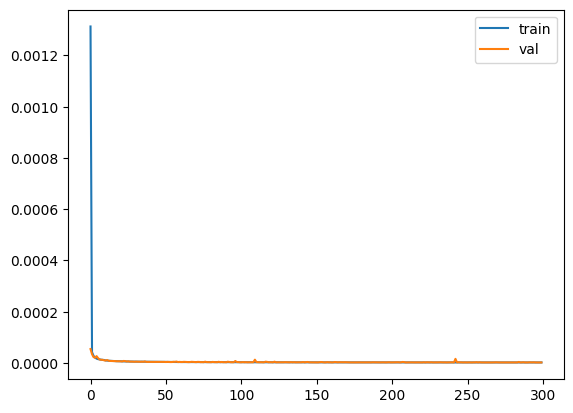

37946/37946 [==============================] - 68s 2ms/step
mean is 0.00000
min is 0.00000
max is 0.03152
std is 0.00004
calculated tr is 4.004452827198564e-05, given tr is 0.02
143788/143788 [==============================] - 261s 2ms/step


<Figure size 1000x700 with 0 Axes>

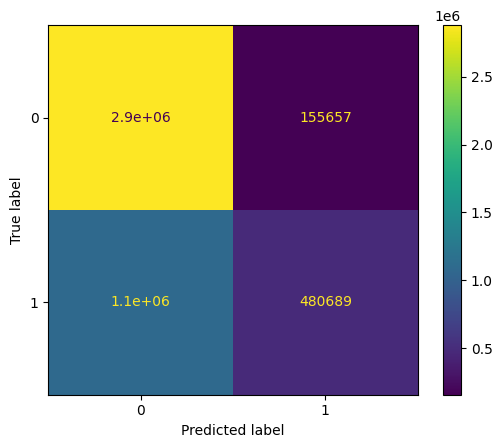

              precision    recall  f1-score   support

           0       0.73      0.95      0.82   3035627
           1       0.76      0.31      0.44   1565578

    accuracy                           0.73   4601205
   macro avg       0.74      0.63      0.63   4601205
weighted avg       0.74      0.73      0.69   4601205

[[0.94872328 0.05127672]
 [0.69296388 0.30703612]]
With the given threshold


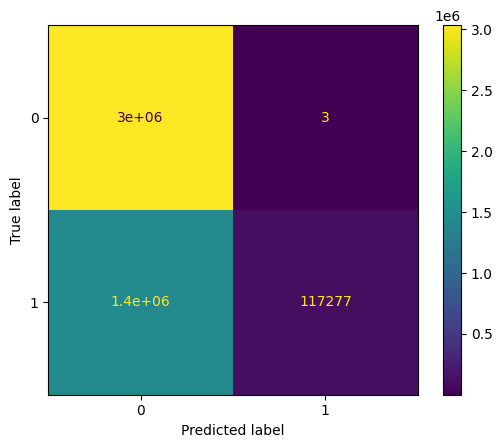

              precision    recall  f1-score   support

           0       0.68      1.00      0.81   3035627
           1       1.00      0.07      0.14   1565578

    accuracy                           0.69   4601205
   macro avg       0.84      0.54      0.47   4601205
weighted avg       0.79      0.69      0.58   4601205

[[9.99999012e-01 9.88263710e-07]
 [9.25090286e-01 7.49097139e-02]]


In [15]:
model_storage = '/content/gdrive/MyDrive/Network Security/models/medbiot/'
pkl_files = '/content/gdrive/MyDrive/Network Security/pkl_files/medbiot/'

name = 'autoencMed'
amodel = model_storage + name
apath = pkl_files
data = [pd.read_pickle(apath + fn) for fn in ['X_train.pkl', 'X_val.pkl', 'X_test.pkl', 'y_test.pkl']]

run_model_df(data, lr=-1, epochs=300, thresh=.02, model_filepath=amodel)

Uniquye train (array([0., 1.]), array([ 10467, 248527]))
[12.37193083  0.52105807]
(258994, 1)
float64
unique test (array(['benign', 'malicious'], dtype=object), array([ 2646, 62103]))
unique test (array([0, 1]), array([ 2646, 62103]))
(64749, 115) (array(['benign', 'malicious'], dtype=object), array([ 2646, 62103]))
begin training
Epoch 1/200
203/203 [==============================] - 6s 15ms/step - loss: 60.5122 - accuracy: 0.3977 - recall_6: 0.3723 - precision_6: 0.9995 - f1_score: 0.9884 - val_loss: 1.5507 - val_accuracy: 0.3555 - val_recall_6: 0.3295 - val_precision_6: 1.0000 - val_f1_score: 0.9902
Epoch 2/200
203/203 [==============================] - 2s 12ms/step - loss: 2.4078 - accuracy: 0.4204 - recall_6: 0.3957 - precision_6: 1.0000 - f1_score: 0.9880 - val_loss: 1.0512 - val_accuracy: 0.3767 - val_recall_6: 0.3516 - val_precision_6: 1.0000 - val_f1_score: 0.9879
Epoch 3/200
203/203 [==============================] - 1s 6ms/step - loss: 1.6947 - accuracy: 0.4090 - recall_6: 

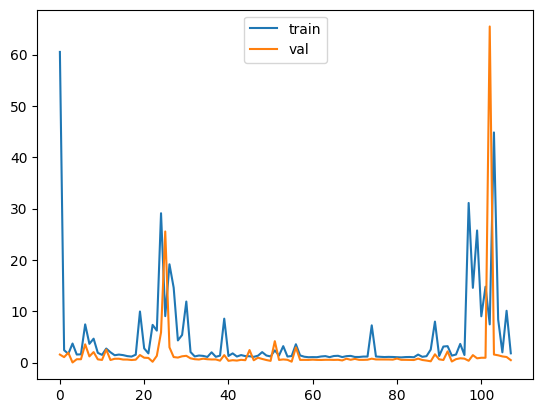

2024/2024 [==============================] - 4s 2ms/step
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


<Figure size 1000x700 with 0 Axes>

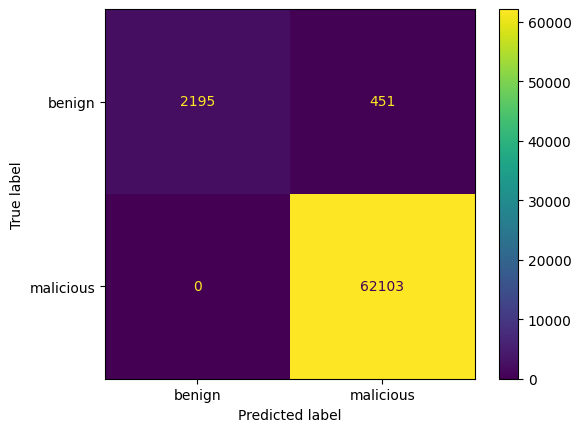

              precision    recall  f1-score   support

           0       1.00      0.83      0.91      2646
           1       0.99      1.00      1.00     62103

    accuracy                           0.99     64749
   macro avg       1.00      0.91      0.95     64749
weighted avg       0.99      0.99      0.99     64749

[[0.82955404 0.17044596]
 [0.         1.        ]]


In [33]:
name = 'hybridMed'
hmodel = model_storage + 'hybrid/' + name
hpath = pkl_files + 'hybrid/'
hybrid_data = [pd.read_pickle(hpath + fn) for fn in ['X_train.pkl', 'X_test.pkl', 'y_train.pkl', 'y_test.pkl']]
train_hybrid_model(hybrid_data, epochs=200, lr=-1, model_filepath=hmodel)

Uniquye train (array([0., 1.]), array([ 10467, 248527]))
[12.37193083  0.52105807]
(258994, 1)
float64
unique test (array(['benign', 'malicious'], dtype=object), array([ 2646, 62103]))
unique test (array([0, 1]), array([ 2646, 62103]))
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 115, 1)]          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 111, 64)           384       
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 55, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_7 (Conv1D)           (None, 51, 32)            10272     
                                                                 
 max_pooling1d_11 (MaxP

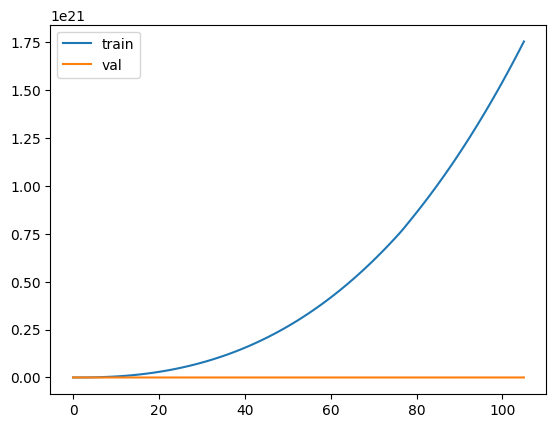

2024/2024 [==============================] - 8s 3ms/step
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1000x700 with 0 Axes>

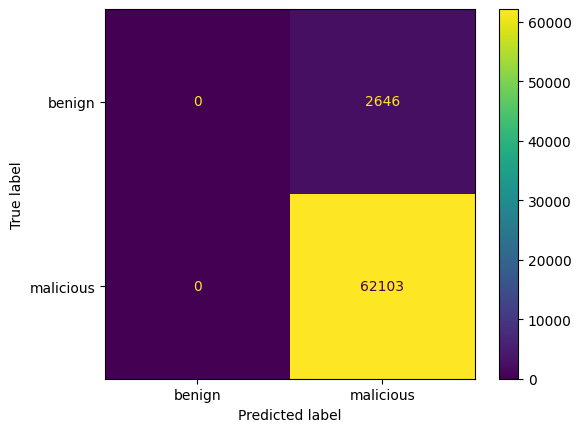

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2646
           1       0.96      1.00      0.98     62103

    accuracy                           0.96     64749
   macro avg       0.48      0.50      0.49     64749
weighted avg       0.92      0.96      0.94     64749

[[0. 1.]
 [0. 1.]]


In [13]:
name = 'cnnMed'
cmodel = model_storage + 'cnn/' + name
cpath = pkl_files + 'hybrid/'
hybrid_data = [pd.read_pickle(cpath + fn) for fn in ['X_train.pkl', 'X_test.pkl', 'y_train.pkl', 'y_test.pkl']]
train_cnn_model(hybrid_data, epochs=200, lr=-1, model_filepath=cmodel)

# Old Stuff

In [ ]:
print('read it in')
# tst_fn='mirai_testing.pkl'
# train_fn='mirai_training.pkl'
# training_df = pd.read_pickle(train_fn)
# print('read it in')
# testing_df = pd.read_pickle(tst_fn)

pth = '/content/gdrive/MyDrive/Network Security/pkl_files/'
training_data = [pd.read_pickle(pth + fn) for fn in ['X_train.pkl', 'X_val.pkl', 'X_test.pkl', 'y_test.pkl']]

read it in


In [ ]:
y_true, test_labels = run_model_df(training_data, thresh=0.011, learnr=0.028, epochs=250)

begin training
Epoch 1/250
350/350 [==============================] - 3s 5ms/step - loss: 0.0159 - accuracy: 0.2448 - recall_4: 0.1713 - precision_4: 0.9976 - f1_score: 0.0080 - val_loss: 0.0047 - val_accuracy: 0.3070 - val_recall_4: 0.1892 - val_precision_4: 0.9999 - val_f1_score: 0.0045
Epoch 2/250
350/350 [==============================] - 1s 4ms/step - loss: 0.0045 - accuracy: 0.2086 - recall_4: 0.1831 - precision_4: 0.9999 - f1_score: 0.0074 - val_loss: 0.0043 - val_accuracy: 0.6427 - val_recall_4: 0.1889 - val_precision_4: 0.9998 - val_f1_score: 0.0102
Epoch 3/250
350/350 [==============================] - 2s 4ms/step - loss: 0.0042 - accuracy: 0.2032 - recall_4: 0.1858 - precision_4: 0.9999 - f1_score: 0.0098 - val_loss: 0.0041 - val_accuracy: 0.4088 - val_recall_4: 0.1954 - val_precision_4: 0.9999 - val_f1_score: 0.0102
Epoch 4/250
350/350 [==============================] - 2s 4ms/step - loss: 0.0038 - accuracy: 0.2288 - recall_4: 0.1880 - precision_4: 0.9999 - f1_score: 0.0107

KeyboardInterrupt: ignored

<Figure size 1000x700 with 0 Axes>

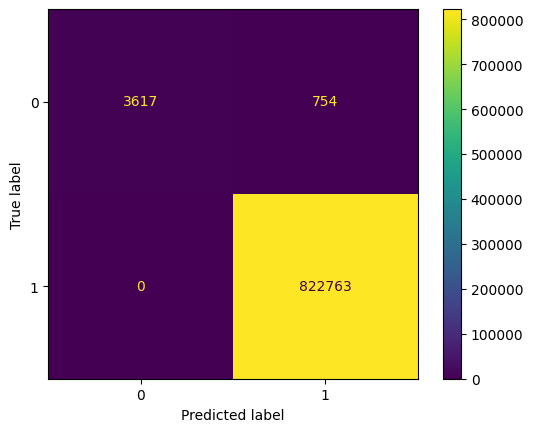

              precision    recall  f1-score   support

           0       1.00      0.83      0.91      4371
           1       1.00      1.00      1.00    822763

    accuracy                           1.00    827134
   macro avg       1.00      0.91      0.95    827134
weighted avg       1.00      1.00      1.00    827134

[[0.82749943 0.17250057]
 [0.         1.        ]]


In [ ]:
cr = classification_report(y_true, test_labels)
cm = confusion_matrix(y_true, test_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (10,7))
ConfusionMatrixDisplay.from_predictions(y_true, test_labels)
plt.show()
print(cr)
print(cm)

This is the hybrid model, which has an encoder then a cnn



```
# Old SHIT: Dont touch me
```